# Evaluating Metagenomic Prediciton of the Metaproteome in a 6 Year Study of a Crohn's Patient

Date: 8/3/2018 <br>
Author: Robert Mills <br>
Environment: Python3

Project Abstract: <br><br>
While genetic approaches are the standard in microbiome analysis, proteome-level information is largely absent and a better understanding of the relationship between genetic copy number and protein abundance is crucial for accurate interpretation of metagenomic data. Additionally, there is currently no understanding of how these relationships are altered during flares in disease states. Patients with inflammatory bowel disease (IBD) experience fluctuations in their gut microbiome which may be related to disease activity. To understand microbial gene and protein fluctuations over a several year period, we leveraged a fecal time series of a single patient with colonic Crohn’s disease. Utilizing multiplexed proteomics and shotgun metagenomics, we quantify over 29,000 proteins and 120,000 genes from the patient’s fecal samples. This study highlights the use of Tandem Mass Tag (TMT) multiplexing proteomics for characterization of the metaproteome, which mediate quantitative comparisons in the context of common clinical diagnostics, serum C-reactive protein, fecal calprotectin, and lysozyme. Results indicate that certain gene types may provide better or worse prediction of protein abundances. Applying linear regressions to clinical metrics showed similar genera level biases while the specific genes correlated to the metrics are unique between the two data types. Additionally, groupings of significantly associated microbial proteins suggest biological insight into host-microbe interactions occurring through time in the Crohn’s disease patient. This proof-of-concept metagenomic-metaproteomic approach warrants further investigation of the metaproteome and its relation to the metagenome

### Load all Dependencies 

In [512]:
import math
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns
from scipy.stats import linregress
import statsmodels
from statsmodels.stats.multitest import fdrcorrection
from matplotlib_venn import venn2

In [2]:
# Makes figures with white background
sns.set_style("white")
%matplotlib inline

### User Defined Functions

In [3]:
ttests=[]
def ttest(df, df_sub1, df_sub2):
    """
    This function takes two subsetted dataframes where
    protein ID's are along the index and the samples
    you are testing are in the columns, and performs a
    ttest to determine whether each protein in the 
    subsets are at different levels. This function
    returns the original dataframe with a new column 
    for the p-value associated with the t-test. 
    equal_var can be set to True or false depending 
    on whether youneed to perform welches correction 
    on the data.
    
    parameters
    ----------
    df: pd.DataFrame
    df_sub1: pd.DataFrame
    df_sub2: pd.DataFrame
    
    returns
    -------
    dataframe with p-values
    
    """
    from scipy.stats import ttest_ind
    df_sub1 = df_sub1.transpose() # Transposition is  required
    df_sub2 = df_sub2.transpose()
    ttests = ttest_ind(df_sub1,df_sub2,equal_var=False,
                       nan_policy='omit')
    ttests = ttests.pvalue.transpose() # Transpose the pvalues back to the original orientation.
    df['ttest_pvalue']=ttests
    return df

In [4]:
def fold(df, sub1, sub2, sub1name, sub2name):
    """
    Creates a new column in your dataframe (df) for fold change between
    two sample types (in separate dataframes sub1 and sub2).
    
    Parameters
    ----------
    df : pd.DataFrame
    sub1 : pd.DataFrame
    sub2 : pd.DataFrame
    sub1name : string
    sub2name : string
    
    Returns
    -------
    Newly formed column in your dataframe.
    """
    df['%s Mean' % (sub1name)]=sub1.mean(axis=1,skipna=True)
    df['%s Mean' % (sub2name)]=sub2.mean(axis=1,skipna=True)
    df['Fold Change(%s/%s)' % (sub1name, sub2name)]=df['%s Mean' % (sub1name)]/df['%s Mean' % (sub2name)]
    return df['Fold Change(%s/%s)' % (sub1name, sub2name)]

In [5]:
def piscore(df,sub1name,sub2name):
    """
    pi score is a function which combines outputs from ttest and fold change functions
    and multiplies them to help pick biologically relevant hits within your systems.
    
    Parameters
    ----------
    df : pd.DataFrame
    sub1name : string
    sub2name: string
    
    Returns
    -------
    Newly formed column in your dataframe
    
    
    """
    df['Log2(Fold Change)'] = np.log2(df['Fold Change(%s/%s)'% (sub1name,sub2name)])
    df['-Log(P-value)'] = -np.log10(df['ttest_pvalue'])
    df['%s/%s pi score' % (sub1name,sub2name)] = df['-Log(P-value)']*df['Log2(Fold Change)']
    return df['%s/%s pi score' % (sub1name,sub2name)]

In [6]:
def TwoCategoryMaster(dfmain,dfsub1,dfsub2,sub1name,sub2name):
    """
    This function combines previously created user-defined functions to streamline the data
    analysis.
    
    Parameters
    ----------
    dfmain : pd.DataFrame
    dfsub1 : pd.DataFrame
    dfsub2 : pd.DataFrame
    sub1name : string
    sub2name : string
    
    Returns
    -------
    Updated dataframe
    """
    ttest(dfmain,dfsub1,dfsub2)
    fold(dfmain,dfsub1,dfsub2,sub1name,sub2name)
    piscore(dfmain,sub1name,sub2name)
    return dfmain

In [7]:
def avgstd(df,colmean,colstd,col1,col2,col3):
    """
    Creates new columns in your dataframe calculating the average and the standard deviation of three replicates.
    NAs are skipped
    
    Parameters
    ----------
    df : Input dataframe (pd.Dataframe)
    colmean : Name for the mean column (string) 
    colstd : Name for the standard deviation column (string)
    col1 : Name of technical replicate column (string)
    col2 : Name of technical replicate column (string)
    col3 : Name of technical replicate column (string)
    
    Returns
    -------
    Newly formed columns in your dataframe
    """
    df[colmean] = df[[col1,col2,col3]].mean(axis=1, skipna=True)
    df[colstd] = df[[col1,col2,col3]].std(axis=1, skipna=True)
    return df[colmean], df[colstd]

### Load data

In [89]:
#Read in metadata
meta = pd.read_csv('LS_Metadata.txt', sep = '\t', index_col = 'SampleID')
protein_meta_IGC = pd.read_csv('./IGC_Approach/Protein_Metadata(wHuman).csv', index_col = 'datarest$ProteinID')
protein_meta = pd.read_csv('./Duplicate_Peptide_Filter/pDB_UniProtKB.txt', sep = '\t')
protein_taxa = pd.read_csv('../Shotgun/Taxa_annotations_expanded.csv')
MG_ann = pd.read_csv('../Shotgun/MG_UniprotKB_Annotations.txt', sep = '\t')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [41]:
#Annotate COG Categories
COG = pd.read_csv('../../Georgia State Collaboration/COG.description.csv')
COG.columns = ['COG', 'COG Protein Name']
COG_cats = pd.read_csv('../../Georgia State Collaboration/COG.funccat.csv')
COG_cats.columns = ['COG', 'eggNOG_Code']
Cat_key = pd.read_csv('../../Georgia State Collaboration/eggNOG_FunCats.csv')

In [93]:
#Read in data tables

#Metaproteome data table
df = pd.read_csv("./Duplicate_Peptide_Filter/pDB_CSVs/NormalizedDataAll_uniref50.csv", index_col = 'datarest$ProteinID')
df_IGC = pd.read_csv("./Duplicate_Peptide_Filter/IGC_CSVs/NormalizedDataAll.txt", index_col='datarest$ProteinID', sep='\t')

#Metagenome data table
MG = pd.read_csv("../Shotgun/Salmon_CPMs_Uniprot_Alignment.csv")

### Figure 2A - Quantity of genes and proteins present in dataset

In [15]:
#Create a list of the 24 samples
samples = ['LS3.23.14_2', 'LS5.22.16_3', 'LS12.7.14_3', 'LS4.3.12_3',
       'LS9.24.13_2', 'LS2.17.14_2', 'LS12.28.11_1', 'LS7.14.13_1',
       'LS9.24.13_1', 'LS12.28.11_2', 'LS5.22.16_2', 'LS7.14.13_2',
       'LS4.3.12_2', 'LS12.7.14_1', 'LS3.23.14_3', 'LS2.17.14_3', 'LS4.3.12_1',
       'LS7.14.13_3', 'LS2.17.14_1', 'LS12.28.11_3', 'LS3.23.14_1',
       'LS9.24.13_3', 'LS5.22.16_1', 'LS12.7.14_2']
#Display the number of samples present
len(samples)

24

<b>Total Protein Stats

In [14]:
#29372 proteins in total in pDB metaproteome
len(df)

29372

In [16]:
#Subset out the proteins shared in all of the samples
#15461 proteins shared by all samples in pDB metaproteome
df_samples = df[samples]
len(df_samples.dropna())

15461

In [23]:
#25012 proteins in total in IGC metaproteome
len(df_IGC)

25098

In [63]:
#16371 proteins shared by all samples in the IGC metaproteome
len(df_IGC.dropna())
df_IGC.dropna()

,LS3.23.14_2,LS5.22.16_3,LS12.7.14_3,LS4.3.12_3,LS9.24.13_2,LS2.17.14_2,LS12.28.11_1,LS7.14.13_1,LS9.24.13_1,LS12.28.11_2,...,LS3.23.14_3,LS2.17.14_3,LS4.3.12_1,LS7.14.13_3,LS2.17.14_1,LS12.28.11_3,LS3.23.14_1,LS9.24.13_3,LS5.22.16_1,LS12.7.14_2
datarest$ProteinID,,,,,,,,,,,,,,,,,,,,,
1006551.KOX_10845,188.764269,228.698304,103.984834,220.732623,295.972860,169.187390,190.678108,121.687567,238.851123,295.579877,...,154.860741,150.397797,165.867339,119.182365,167.791067,215.032598,213.150738,282.096274,209.934681,125.307256
1006551.KOX_23660,177.220040,129.370672,100.194116,189.297416,408.181137,167.916850,147.090266,149.519797,511.267711,177.071744,...,209.649618,159.370721,249.608867,147.469467,156.019643,175.754623,162.458340,444.636099,142.517469,45.211624
1006551.KOX_24100,126.643135,141.690253,73.411600,202.740771,380.063162,90.991845,133.070283,166.689317,437.747671,190.871087,...,173.299295,178.461850,223.150977,156.143081,107.947081,187.285778,138.860719,362.404358,176.699745,67.560085
1028307.EAE_00320,168.812086,191.618094,118.011400,164.324660,496.050759,149.810617,67.054894,125.065733,545.674790,160.242963,...,148.579950,178.006511,167.991800,68.383785,139.895949,97.792442,174.860180,518.491290,207.558505,67.415932
1028307.EAE_03995,169.063676,176.376299,9.941114,185.596804,378.077739,141.009185,282.207713,143.931917,336.505112,138.032853,...,175.798122,124.583876,182.556590,176.376602,239.007149,301.985031,155.194136,353.546368,50.520276,5.267110
1028307.EAE_09510,216.747872,231.562376,31.263839,178.298844,361.572198,241.713307,104.959015,118.476077,393.749099,140.018053,...,237.397729,243.713885,173.827849,98.913614,296.657771,121.371805,223.223621,393.529368,237.724959,21.167989
1028307.EAE_24020,183.694678,146.679967,32.734888,199.146501,552.689967,160.595571,240.874701,171.817393,445.762564,238.804816,...,165.408580,124.488810,200.260646,259.520072,115.389749,179.905774,146.021305,400.926025,146.116007,30.193734
1033813.ECNA114_3664,145.491273,65.238480,21.180348,323.984649,488.040344,157.853151,115.142458,119.715846,533.029440,106.313966,...,145.821259,153.151478,320.051509,105.220009,167.898962,136.540614,140.480310,528.604747,67.606313,19.749919
1033813.ECNA114_4058,211.719335,181.068056,54.885078,187.152016,394.278554,178.891830,131.159156,146.752791,391.465674,123.524559,...,254.858497,222.875598,200.109784,133.685491,193.876556,131.558769,218.998772,375.528387,166.305815,69.266899


<b>Human Protein Stats

In [62]:
#pDB Human Proteins
#Prodigal annotates their ORFs with 'k99_', so checking those without that value results in the number of human proteins:
len(df[df.index.str.contains('k99_') == False])

933

In [64]:
#pDB Human Proteins shared by all samples
df_samples_shared = df_samples.dropna()
len(df_samples_shared[df_samples_shared.index.str.contains('k99_') == False])

423

In [67]:
#IGC Human Proteins
df_IGC = df_IGC.merge(protein_meta_IGC, left_index = True, right_index = True, how = 'left')
df_IGC


,LS3.23.14_2,LS5.22.16_3,LS12.7.14_3,LS4.3.12_3,LS9.24.13_2,LS2.17.14_2,LS12.28.11_1,LS7.14.13_1,LS9.24.13_1,LS12.28.11_2,...,Taxonomic Annotation(Genus Level),KO,eggNOG,Sample Occurence Frequency,Individual Occurence Frequency,KEGG Functional Categories,eggNOG Functional Categories,Cohort Assembled,COG,COG Protein Name
datarest$ProteinID,,,,,,,,,,,,,,,,,,,,,
1006551.KOX_01155,127.625094,165.439892,18.406597,170.535214,378.950048,92.536529,104.671495,84.480352,NaN,NaN,...,Klebsiella,K00951,COG0317,0.026835,0.024299,Nucleotide Metabolism,Transcription;Signal transduction mechanisms,NaN,COG0317,Guanosine polyphosphate pyrophosphohydrolases/...
1006551.KOX_04715,219.525252,168.735629,41.785941,240.551824,446.524831,144.386710,165.458162,164.371350,NaN,NaN,...,Klebsiella,K00688,COG0058,0.034728,0.032710,Carbohydrate Metabolism,Carbohydrate transport and metabolism,EUR,COG0058,Glucan phosphorylase
1006551.KOX_10165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Klebsiella,K10708,COG2222,0.018153,0.016822,Metabolism,Cell wall/membrane/envelope biogenesis,NaN,COG2222,Predicted phosphosugar isomerases
1006551.KOX_10845,188.764269,228.698304,103.984834,220.732623,295.972860,169.187390,190.678108,121.687567,238.851123,295.579877,...,Klebsiella,K01703,COG0065,0.018153,0.014953,Carbohydrate Metabolism,Amino acid transport and metabolism,EUR,COG0065,3-isopropylmalate dehydratase large subunit
1006551.KOX_17365,208.341471,220.909456,54.630993,165.477241,377.862428,260.387306,172.638833,150.162244,NaN,NaN,...,Klebsiella,K07000,COG3150,0.010260,0.009346,Poorly Characterized,General function prediction only,NaN,COG3150,Predicted esterase
1006551.KOX_20030,159.040655,141.504684,25.379370,204.147113,266.333595,194.752709,223.230752,107.290904,NaN,NaN,...,Klebsiella,K08348,COG0243,0.031571,0.031776,Carbohydrate Metabolism,Energy production and conversion,EUR,COG0243,"Anaerobic dehydrogenases, typically selenocyst..."
1006551.KOX_23075,109.050515,85.785557,57.707154,361.902135,506.646896,91.670203,75.062880,142.214491,NaN,NaN,...,Klebsiella,K00371,COG1140,0.033938,0.032710,Energy Metabolism,Energy production and conversion,EUR,COG1140,Nitrate reductase beta subunit
1006551.KOX_23660,177.220040,129.370672,100.194116,189.297416,408.181137,167.916850,147.090266,149.519797,511.267711,177.071744,...,Klebsiella,K02796,COG3716,0.031571,0.028972,Carbohydrate Metabolism,Carbohydrate transport and metabolism,EUR,COG3716,"Phosphotransferase system, mannose/fructose/N-..."
1006551.KOX_24100,126.643135,141.690253,73.411600,202.740771,380.063162,90.991845,133.070283,166.689317,437.747671,190.871087,...,Klebsiella,K00995,COG0558,0.011839,0.011215,Lipid Metabolism,Lipid transport and metabolism,EUR;CHN,COG0558,Phosphatidylglycerophosphate synthase


In [85]:
#Number of human proteins within IGC in total
df_IGC_human = df_IGC[df_IGC['Taxonomic Annotation(Phylum Level)'] == 'Homo sapiens (Human)']
len(df_IGC_human)

912

In [84]:
#Number of human proteins in IGC with genes in all samples
len(df_IGC_human[samples].dropna())

434

<b>Metagenomic Genes Stats

In [94]:
#Remove the genes with duplicate queryIDs
MG = MG.drop_duplicates(subset = 'queryID', keep = 'first')
len(MG)

119653

In [96]:
#Find the number of metagenomic genes that are shared by all 24 samples
len(MG.dropna())

5076

### Figure 2B - Number of overlapping peptides found

In [125]:
#Load in the data tables for IGC and pDB with the specific peptides found
df_IGC_peptides = pd.read_csv('./Duplicate_Peptide_Filter/IGC_Duplicate_Removed.csv')
df_pDB_peptides = pd.read_csv('./Duplicate_Peptide_Filter/pDB_Duplicate_Removed.csv')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [126]:
#Number of PSMs identified in pDB
pDB_peptides = df_pDB_peptides['Annotated Sequence']
len(pDB_peptides)

503353

In [127]:
#Number of PSMs identified in pDB
IGC_peptides = df_IGC_peptides['Annotated Sequence']
len(IGC_peptides)

687197

In [128]:
#Subset to only the unique peptides 
pDB_peptides = set(pDB_peptides.drop_duplicates())
len(pDB_peptides)

94204

In [129]:
#Subset to only the unique peptides 
IGC_peptides = set(IGC_peptides.drop_duplicates())
len(IGC_peptides)

101363

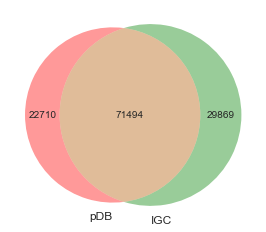

In [124]:
venn = venn2([pDB_peptides, IGC_peptides], ['pDB', 'IGC'])
plt.savefig('./pdfs/Total_peptide_comparisons.pdf')

### Figure 2C - MP Technical Replicates

In [130]:
#Read in data tables

#Metaproteome data table
df = pd.read_csv("./Duplicate_Peptide_Filter/pDB_CSVs/NormalizedDataAll_uniref50.csv", index_col = 'datarest$ProteinID')
df_IGC = pd.read_csv("./Duplicate_Peptide_Filter/IGC_CSVs/NormalizedDataAll.txt", index_col='datarest$ProteinID', sep='\t')

#Metagenome data table
MG = pd.read_csv("../Shotgun/Salmon_CPMs_Uniprot_Alignment.csv")

In [120]:
#Cluster only the proteins shared by all samples
df = df[samples].dropna()

,LS3.23.14_2,LS5.22.16_3,LS12.7.14_3,LS4.3.12_3,LS9.24.13_2,LS2.17.14_2,LS12.28.11_1,LS7.14.13_1,LS9.24.13_1,LS12.28.11_2,...,LS3.23.14_3,LS2.17.14_3,LS4.3.12_1,LS7.14.13_3,LS2.17.14_1,LS12.28.11_3,LS3.23.14_1,LS9.24.13_3,LS5.22.16_1,LS12.7.14_2
datarest$ProteinID,,,,,,,,,,,,,,,,,,,,,
k99_1000192_1,132.240162,128.182893,106.207889,113.250556,68.767526,146.534332,115.097499,140.505533,54.954461,119.944100,...,133.096866,135.746827,102.834852,129.387856,153.995579,96.240629,138.832050,76.331264,148.676331,98.905744
k99_1000497_2,131.543532,119.071840,241.041094,149.645728,82.554611,107.933536,155.855524,151.054945,111.326412,124.036166,...,115.618519,90.691292,141.620494,87.064065,159.175952,108.013774,131.341334,96.848171,101.094367,87.654150
k99_1000590_1,33.969219,21.335567,9.847595,455.562096,356.137409,29.749954,59.457066,12.214501,346.342804,44.739211,...,40.021631,14.873803,125.047702,10.864743,39.668690,28.151094,58.966344,952.830770,12.013966,18.020360
k99_100074_1,92.117803,118.179735,126.085403,153.592976,175.982772,78.502470,123.120660,146.802967,136.341723,90.702158,...,76.308723,72.279580,177.247838,125.925806,88.515169,111.132481,86.441451,140.779552,108.336531,97.247914
k99_1000795_2,91.318417,61.049671,144.229905,140.559944,140.390877,53.103524,24.716796,273.785346,157.118642,100.478089,...,90.344123,54.297260,123.046941,172.482023,37.018046,40.466201,79.896123,166.409449,59.896240,143.810468
k99_1000868_4,104.897673,121.443530,149.227558,135.352940,94.292533,64.170421,87.283542,102.931812,126.126221,157.535338,...,84.247123,99.382386,104.166998,121.989860,113.972986,111.495856,118.933019,93.948001,125.864999,174.772954
k99_1000868_6,63.418668,156.919162,145.164516,109.627381,223.859252,46.383422,80.973596,153.936420,189.733900,97.158435,...,78.455633,70.636882,113.733020,131.555976,60.538596,81.640400,63.326411,218.452352,152.513512,128.623584
k99_1000937_1,115.400761,142.792796,104.870742,148.895608,85.997477,128.809715,151.764455,87.671703,85.105016,142.881864,...,108.032747,104.999858,164.412097,93.010784,108.884282,139.966542,113.519308,88.494742,129.780241,112.578284
k99_1001068_2,102.445349,87.944409,74.439215,210.959113,117.406096,88.354915,183.661575,108.774135,123.578407,251.307427,...,102.414887,82.726313,229.518277,98.380010,81.648786,190.230591,103.035467,131.686174,79.188429,80.281978


/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


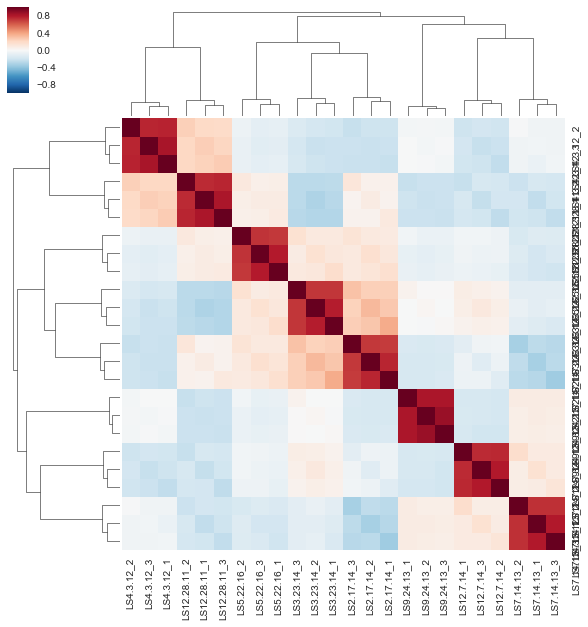

In [123]:
#Perform spearman correlations and hierarchical clustering
corr = df.corr(method='spearman')
sns.clustermap(corr)
plt.savefig("./pdfs/pDB_Shared_Technical_Correlation_Plot.pdf")

### Figure 2D - MP MG Dynamic Range Comparison

In [233]:
#Read in data tables

#Metaproteome data table
df = pd.read_csv("./Duplicate_Peptide_Filter/pDB_CSVs/NormalizedDataAll_uniref50.csv", index_col = 'datarest$ProteinID')
df_IGC = pd.read_csv("./Duplicate_Peptide_Filter/IGC_CSVs/NormalizedDataAll.txt", index_col='datarest$ProteinID', sep='\t')

#Metagenome data table
MG = pd.read_csv("../Shotgun/Salmon_CPMs_Uniprot_Alignment.csv")

In [234]:
#Remove the genes with duplicate queryIDs
MG = MG.drop_duplicates(subset = 'queryID', keep = 'first')

In [235]:
#First make a list of the dates you want to average and get the standard deviation for
dates = ['LS12.28.11','LS4.3.12','LS7.14.13','LS9.24.13','LS2.17.14','LS3.23.14','LS12.7.14','LS5.22.16']

In [236]:
#Generate averages and standard deviations for the technical replicates
#Averages skip NAs
for i in dates:
    avgstd(df,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

In [237]:
for i in dates:
    avgstd(MG,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

In [238]:
#Change the index name
MG.index = MG['queryID']

In [239]:
#Subset to only look at the averages
dfcategories2 = MG[dates]
dfcategories = df[dates]

In [240]:
#To determine dynamic ranges, we are using only the genes which have at least one measurement at each date.
#This is to have a more comparable method to the metaproteome, which has at least one value in every protein.
dfcategories2 = dfcategories2.dropna()

In [241]:
#Calculate the standard deviation of each protein and gene
dfcategories["Std"] = dfcategories[dates].std(axis = 1)
dfcategories2["Std"] = dfcategories2[dates].std(axis = 1)

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [242]:
#Find the maximum value
dfcategories['Max'] = dfcategories[dates].max(axis=1)
dfcategories2['Max'] = dfcategories2[dates].max(axis=1)

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [243]:
#Find the minimum value
dfcategories['Min'] = dfcategories[dates].min(axis=1)
dfcategories2['Min'] = dfcategories2[dates].min(axis=1)

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [244]:
#Determine the maxmimum/minimum for the dynamic range of each protein or gene
dfcategories["Max/Min"] = dfcategories['Max']/dfcategories['Min']
dfcategories2["Max/Min"] = dfcategories2['Max']/dfcategories2['Min']

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [245]:
#Determine the Max - Min
dfcategories["Max-Min"] = dfcategories['Max']-dfcategories['Min']
dfcategories2["Max-Min"] = dfcategories2['Max']-dfcategories2['Min']

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [246]:
#Remove NAs by selecting for postive values at or above 1
dfcategories = dfcategories[dfcategories['Max/Min'] > 0.9]
dfcategories2 = dfcategories2[dfcategories2['Max/Min'] > 0.9]

In [247]:
#Calculate the log(Max/Min) for display purposes
dfcategories['logMax/Min'] = np.log10(dfcategories['Max/Min'])
dfcategories2['logMax/Min'] = np.log10(dfcategories2['Max/Min'])

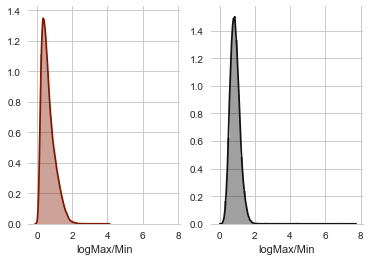

In [248]:
#Set style to have grids
sns.set_style("whitegrid")
# Set up the matplotlib figure
f, axes = plt.subplots(1,2, sharex=True)
sns.despine(left=True)
sns.distplot(dfcategories['logMax/Min'], ax=axes[0],color ='#811700')
sns.distplot(dfcategories2['logMax/Min'], ax=axes[1],color ='#131313')
plt.savefig('./pdfs/pDB_MG_DynamicRangeDistributionGenes_sns_new?.pdf')

In [249]:
#Find the statistics associated with each distribution
scipy.stats.describe(dfcategories['logMax/Min'])

DescribeResult(nobs=29371, minmax=(0.043770564365426125, 3.973564611253065), mean=0.6440634707643854, variance=0.13969616739852095, skewness=1.0808375604439084, kurtosis=1.2580591486258346)

In [250]:
#Find the statistics associated with each distribution
scipy.stats.describe(dfcategories2['logMax/Min'])

DescribeResult(nobs=26575, minmax=(0.12203479716252935, 7.6351616328162), mean=0.8778940725660788, variance=0.07775498920736791, skewness=1.7229134304985787, kurtosis=24.93210336111696)

### Figure 2E - MP MG Spearman Correlation Distribution


In [329]:
#Read in data tables

#Metaproteome data table
df = pd.read_csv("./Duplicate_Peptide_Filter/pDB_CSVs/NormalizedDataAll_uniref50.csv", index_col = 'datarest$ProteinID')
df_IGC = pd.read_csv("./Duplicate_Peptide_Filter/IGC_CSVs/NormalizedDataAll.txt", index_col='datarest$ProteinID', sep='\t')

#Metagenome data table
MG = pd.read_csv("../Shotgun/Salmon_CPMs_Uniprot_Alignment.csv")
#Remove the genes with duplicate queryIDs
MG = MG.drop_duplicates(subset = 'queryID', keep = 'first')

In [330]:
#First make a list of the dates you want to average and get the standard deviation for
dates = ['LS12.28.11','LS4.3.12','LS7.14.13','LS9.24.13','LS2.17.14','LS3.23.14','LS12.7.14','LS5.22.16']

In [331]:
#Generate averages and standard deviations for the technical replicates
for i in dates:
    avgstd(df,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

In [332]:
for i in dates:
    avgstd(MG,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

In [333]:
#Change the index name
MG.index = MG['queryID']

In [334]:
#Subset to only look at the averages
dfcategories2 = MG[dates]
dfcategories = df[dates]

In [335]:
#To determine spearman correlations, we are replacing the missing values with 0s as the absence
#of a gene is possibly accounted for by the fact that it is not there.
dfcategories2 = dfcategories2.replace(np.nan, 0)

In [336]:
#Analyze only the genes which have protein level quanties
merge = dfcategories.merge(dfcategories2, left_index = True, right_index = True)

In [398]:
#Generate a list of IDS shared between the metagenome and metaproteome
shared = list(merge.index)

In [399]:
#Make a subsetted dataframe with only the ORFs shared between the two datasets
dfMP = dfcategories.loc[shared]
dfMG = dfcategories2.loc[shared]

In [400]:
#Create a transposed dataframe as a prerequisite for the next function
dfMP2 = dfMP.T
dfMG2 = dfMG.T

In [401]:
#Perform spearman correlations on each shared protein
corrs = []
for i in shared:
    corr = dfMP2['%s' % i].corr(dfMG2['%s' % i], method='spearman')
    corrs.append(corr)

In [402]:
#Generate a dataframe with all the spearman correlations
corrsdf = pd.DataFrame(
{'shared_genes' : shared,
 'Spearman_Corr' : corrs})

In [403]:
#Drop the genes which a spearman correlation could not be made due to lack of viable data in the metagenome
corrsdf = corrsdf.dropna()

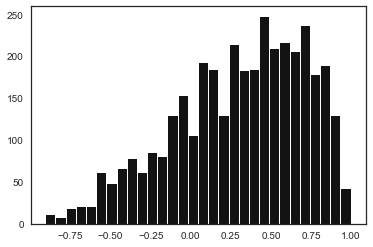

In [271]:
#Set style to have not have grids
sns.set_style("white")
plt.hist(corrsdf["Spearman_Corr"], color ='#131313', rwidth = 0.9, bins = 30)
plt.savefig('./pdfs/MPMG_Genes_SpearmanCorrelationDistributions_0forna_30bins.pdf')

In [272]:
#Descriptive statistics on the distribution
scipy.stats.describe(corrsdf['Spearman_Corr'])

DescribeResult(nobs=3666, minmax=(-0.9047619047619048, 1.0), mean=0.3038441258911027, variance=0.1660633442528294, skewness=-0.519502134643939, kurtosis=-0.45948680624207583)

### Figure 3A - Spearman Correlation Breakdown by eggNOG

<i>Continue from Figure 2E Code

In [370]:
#Determine the UniprotKBs associated with each prodigal ID
MG = pd.read_csv("../Shotgun/Salmon_CPMs_Uniprot_Alignment.csv")
MG.columns

Index(['Unnamed: 0', 'LS12.28.11_1', 'LS12.28.11_2', 'LS12.28.11_3',
       'LS4.3.12_1', 'LS4.3.12_2', 'LS4.3.12_3', 'LS7.14.13_1', 'LS7.14.13_2',
       'LS7.14.13_3', 'LS9.24.13_1', 'LS9.24.13_2', 'LS9.24.13_3',
       'LS2.17.14_1', 'LS2.17.14_2', 'LS2.17.14_3', 'LS3.23.14_1',
       'LS3.23.14_2', 'LS3.23.14_3', 'LS12.7.14_1', 'LS12.7.14_2',
       'LS12.7.14_3', 'LS5.22.16_1', 'LS5.22.16_2', 'LS5.22.16_3', 'queryID',
       'subjectID', 'percIdentity', 'alnLength', 'mismatchCount',
       'gapOpenCount', 'queryStart', 'queryEnd', 'subjectStart', 'subjectEnd',
       'eVal', 'bitScore'],
      dtype='object')

In [394]:
#Read in metadata
meta = pd.read_csv('LS_Metadata.txt', sep = '\t', index_col = 'SampleID')
protein_meta_IGC = pd.read_csv('./IGC_Approach/Protein_Metadata(wHuman).csv', index_col = 'datarest$ProteinID')
protein_meta = pd.read_csv('./Duplicate_Peptide_Filter/pDB_UniProtKB.txt', sep = '\t')
protein_taxa = pd.read_csv('../Shotgun/Taxa_annotations_expanded.csv')
MG_ann = pd.read_csv('../Shotgun/MG_UniprotKB_Annotations.txt', sep = '\t')
#For annotating with COG assignments and corresponding eggNOG
COG = pd.read_csv('../../Georgia State Collaboration/COG.description.csv')
COG.columns = ['COG', 'COG Protein Name']
COG_cats = pd.read_csv('../../Georgia State Collaboration/COG.funccat.csv')
COG_cats.columns = ['COG', 'eggNOG_Code']
Cat_key = pd.read_csv('../../Georgia State Collaboration/eggNOG_FunCats.csv')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [415]:
#Retrieve prodigal alignments to the uniref_50
Uniprot = pd.concat([MG['queryID'],MG['subjectID']], axis = 1).drop_duplicates()

#Add annotation information on the shared dataframe
merge2 = merge.merge(Uniprot, left_index = True, right_on = "queryID", how = 'left')
merge2 = merge2.merge(protein_taxa, left_on = 'queryID', right_on = 'Ref_ID', how = 'left')
merge2 = merge2.merge(protein_meta, left_on = 'subjectID', right_on = 'Entry', how = 'left')
merge2 = merge2.merge(corrsdf, left_on = 'Ref_ID', right_on = 'shared_genes', how = 'left')

In [417]:
#Split up protein metadata for pDB if you want to add COG categories...
s = merge2['Cross-reference (eggNOG)'].str.split(';').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1) # to line up with df's index
s.name = 'Parsed_Categories'
merge3 = merge2.join(s)
merge3['Parsed_Categories'] = merge3['Parsed_Categories'].str.strip()

In [418]:
#Add eggNOG annotations
merge3 = merge3.merge(COG_cats, left_on = "Parsed_Categories", right_on = 'COG', how = 'left')
merge3 = merge3.merge(Cat_key, left_on = 'eggNOG_Code', right_on = 'eggNOG Functional Assignment', how = 'left')
merge3 = merge3.merge(COG, left_on = 'COG', right_on = 'COG', how = 'left')

,LS12.28.11_x,LS4.3.12_x,LS7.14.13_x,LS9.24.13_x,LS2.17.14_x,LS3.23.14_x,LS12.7.14_x,LS5.22.16_x,LS12.28.11_y,LS4.3.12_y,...,Cross-reference (KEGG),Spearman_Corr,shared_genes,Parsed_Categories,COG,eggNOG_Code,eggNOG Functional Assignment,eggNOG Subgroup,Description,COG Protein Name
0,168.940314,115.623387,69.936235,172.694078,110.145594,119.321443,86.733568,118.902113,3.935553,0.000000,...,NaN,0.608816,k99_100028_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,83.376280,75.584058,163.042306,79.668770,85.960781,84.939164,160.561600,92.413213,0.616295,1.204545,...,NaN,0.500000,k99_100044_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,275.244328,105.264589,58.016207,163.342699,180.354974,82.985652,89.167111,138.191467,0.435531,0.000000,...,NaN,-0.586837,k99_100044_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,108.318433,151.882825,133.959840,151.034682,79.765739,84.955992,120.375431,111.686874,3.010477,2.334737,...,rto:RTO_09120;,0.238095,k99_100074_1,ENOG4105C6N,NaN,NaN,NaN,NaN,NaN,NaN
4,108.318433,151.882825,133.959840,151.034682,79.765739,84.955992,120.375431,111.686874,3.010477,2.334737,...,rto:RTO_09120;,0.238095,k99_100074_1,COG1882,COG1882,C,C,Metabolism,Energy production and conversion,Pyruvate-formate lyase
5,108.318433,151.882825,133.959840,151.034682,79.765739,84.955992,120.375431,111.686874,3.010477,2.334737,...,rto:RTO_09120;,0.238095,k99_100074_1,,NaN,NaN,NaN,NaN,NaN,NaN
6,126.862110,95.810938,178.665577,140.798361,101.866686,77.005184,115.877019,154.168430,0.847238,1.547398,...,ctc:CTC_01743;,0.571429,k99_100111_1,ENOG4105DVQ,NaN,NaN,NaN,NaN,NaN,NaN
7,126.862110,95.810938,178.665577,140.798361,101.866686,77.005184,115.877019,154.168430,0.847238,1.547398,...,ctc:CTC_01743;,0.571429,k99_100111_1,COG0707,COG0707,M,M,Cellular processes and signaling,Cell wall/membrane/envelope biogenesis,UDP-N-acetylglucosamine:LPS N-acetylglucosamin...
8,126.862110,95.810938,178.665577,140.798361,101.866686,77.005184,115.877019,154.168430,0.847238,1.547398,...,ctc:CTC_01743;,0.571429,k99_100111_1,,NaN,NaN,NaN,NaN,NaN,NaN
9,132.354288,95.737090,129.485105,99.602876,106.787385,118.646784,152.595665,107.137466,1.482103,0.970684,...,bprs:CK3_21400;,0.595238,k99_100163_1,ENOG4105CQI,NaN,NaN,NaN,NaN,NaN,NaN


In [419]:
#Get a list of the eggNOG categories
cats = list(merge3['Description'].drop_duplicates())

In [421]:
#Generate statistics about each eggNOG category
medians = []
means = []
stds = []
for i in  cats:
    sub = merge3[merge3['Description'] == i]
    med = sub['Spearman_Corr'].median()
    mean = sub['Spearman_Corr'].mean()
    std = sub['Spearman_Corr'].std()
    medians.append(med)
    means.append(mean)
    stds.append(std)

In [420]:
#Melt the spearman correlations for use with seaborn visualization
id_vars = ['Description', 'COG']
value_vars = ['Spearman_Corr']
merge_melt = pd.melt(merge3, id_vars = id_vars, value_vars = value_vars)

,Description,COG,variable,value
0,NaN,NaN,Spearman_Corr,0.608816
1,NaN,NaN,Spearman_Corr,0.500000
2,NaN,NaN,Spearman_Corr,-0.586837
3,NaN,NaN,Spearman_Corr,0.238095
4,Energy production and conversion,COG1882,Spearman_Corr,0.238095
5,NaN,NaN,Spearman_Corr,0.238095
6,NaN,NaN,Spearman_Corr,0.571429
7,Cell wall/membrane/envelope biogenesis,COG0707,Spearman_Corr,0.571429
8,NaN,NaN,Spearman_Corr,0.571429
9,NaN,NaN,Spearman_Corr,0.595238


In [422]:
#Generate dataframe with categories information
catsdf = pd.DataFrame(
{'Cat' : cats,
'Median' : medians,
'Mean' : means,
'Standard_Deviation' : stds})

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


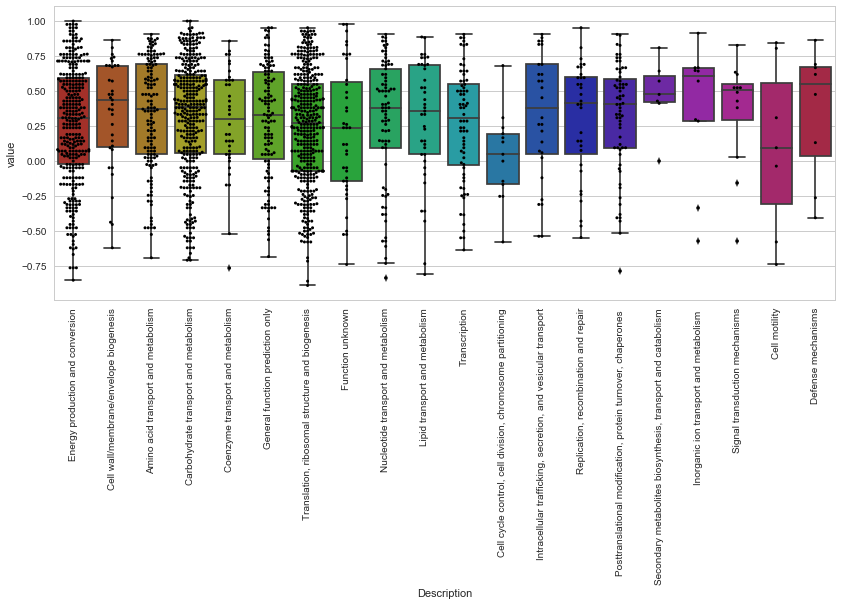

In [424]:
#Plot the spearman distributions in boxplots per category

#Set style to have grids
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize = (14,6))
#sns.violinplot(x = 'value', y = 'Description', inner = None, data = merge_melt,cut=0, palette = sns.hls_palette(20, l=.4, s=.8))
sns.swarmplot(x = 'Description', y = 'value', alpha = 1, data = merge_melt, color = 'black', size=3)
sns.boxplot(x = 'Description', y = 'value', data = merge_melt, palette = sns.hls_palette(20, l=.4, s=.8))
fig.autofmt_xdate(rotation = 90, ha = 'center')
#plt.savefig('./Duplicate_Peptide_Filter/COG_Spearman_Distributions_perGene_Boxes_horizontal.pdf', bbox_inches = 'tight')

### Figure 3B & 3C - Spearman correlations by GO categories

In [462]:
#Read in data tables

#Metaproteome data table
df = pd.read_csv("./Duplicate_Peptide_Filter/pDB_CSVs/NormalizedDataAll_uniref50.csv", index_col = 'datarest$ProteinID')
df_IGC = pd.read_csv("./Duplicate_Peptide_Filter/IGC_CSVs/NormalizedDataAll.txt", index_col='datarest$ProteinID', sep='\t')

#Metagenome data table
MG = pd.read_csv("../Shotgun/Salmon_CPMs_Uniprot_Alignment.csv")
#Remove the genes with duplicate queryIDs
MG = MG.drop_duplicates(subset = 'queryID', keep = 'first')

In [463]:
#Read in metadata
meta = pd.read_csv('LS_Metadata.txt', sep = '\t', index_col = 'SampleID')
protein_meta_IGC = pd.read_csv('./IGC_Approach/Protein_Metadata(wHuman).csv', index_col = 'datarest$ProteinID')
protein_meta = pd.read_csv('./Duplicate_Peptide_Filter/pDB_UniProtKB.txt', sep = '\t')
protein_taxa = pd.read_csv('../Shotgun/Taxa_annotations_expanded.csv')
MG_ann = pd.read_csv('../Shotgun/MG_UniprotKB_Annotations.txt', sep = '\t')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
samples = ['LS3.23.14_2', 'LS5.22.16_3', 'LS12.7.14_3', 'LS4.3.12_3',
       'LS9.24.13_2', 'LS2.17.14_2', 'LS12.28.11_1', 'LS7.14.13_1',
       'LS9.24.13_1', 'LS12.28.11_2', 'LS5.22.16_2', 'LS7.14.13_2',
       'LS4.3.12_2', 'LS12.7.14_1', 'LS3.23.14_3', 'LS2.17.14_3', 'LS4.3.12_1',
       'LS7.14.13_3', 'LS2.17.14_1', 'LS12.28.11_3', 'LS3.23.14_1',
       'LS9.24.13_3', 'LS5.22.16_1', 'LS12.7.14_2']
len(samples)

In [464]:
MG = MG.merge(MG_ann, left_on = 'subjectID', right_on = 'Entry', how = 'left')
df = df.merge(protein_meta, left_on = 'subjectID', right_on = 'Entry', how = 'left')

In [465]:
#Split up dataframe by metadata for MG if you want to add GO categories...
s = MG['Gene ontology (GO)'].str.split(';').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1) # to line up with df's index
s.name = 'Parsed_Categories'
GO = MG.join(s)
GO['Parsed_Categories'] = GO['Parsed_Categories'].str.strip()

#Group the data by GO terms
dfcategories2 = GO[samples].groupby([GO['Parsed_Categories']]).agg(['sum'])
dfcategories2.columns = dfcategories2.columns.droplevel(1)

In [466]:
#Split up dataframe by protein metadata for pDB if you want to add GO categories...
s = df['Gene ontology (GO)'].str.split(';').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1) # to line up with df's index
s.name = 'Parsed_Categories'
GO = df.join(s)
GO['Parsed_Categories'] = GO['Parsed_Categories'].str.strip()

#Group the data by GO terms
dfcategories = GO[samples].groupby([GO['Parsed_Categories']]).agg(['sum'])
dfcategories.columns = dfcategories.columns.droplevel(1)

In [467]:
#Plotting certain GO categories which had interesting trends

#Selection of categories of interest
MP_Formox = dfcategories.loc['formate oxidation [GO:0015944]']
MG_Formox = dfcategories2.loc['formate oxidation [GO:0015944]']
MP_Formdehydrog = dfcategories.loc['formate dehydrogenase (NAD+) activity [GO:0008863]']
MG_Formdehydrog = dfcategories2.loc['formate dehydrogenase (NAD+) activity [GO:0008863]']

In [468]:
MP_PolyCat = dfcategories.loc['polysaccharide catabolic process [GO:0000272]']
MG_PolyCat = dfcategories2.loc['polysaccharide catabolic process [GO:0000272]']
MG_Carbmeta = dfcategories2.loc['carbohydrate derivative metabolic process [GO:1901135]']
MP_Carbmeta = dfcategories.loc['carbohydrate derivative metabolic process [GO:1901135]']
MG_PolyTrans = dfcategories2.loc['polysaccharide transport [GO:0015774]']
MP_PolyTrans = dfcategories.loc['polysaccharide transport [GO:0015774]']
MG_CarbTrans = dfcategories2.loc['carbohydrate transport [GO:0008643]']
MP_CarbTrans = dfcategories.loc['carbohydrate transport [GO:0008643]']

In [469]:
MP_NitAss = dfcategories.loc['nitrate assimilation [GO:0042128]']
MG_NitAss = dfcategories2.loc['nitrate assimilation [GO:0042128]']
MG_NitRed = dfcategories2.loc['nitrate reductase activity [GO:0008940]']
MP_NitRed = dfcategories.loc['nitrate reductase activity [GO:0008940]']
MG_Anaer = dfcategories2.loc['anaerobic respiration [GO:0009061]']
MP_Anaer = dfcategories.loc['anaerobic respiration [GO:0009061]']
MG_Nit = dfcategories2.loc['nitrogen compound metabolic process [GO:0006807]']
MP_Nit = dfcategories.loc['nitrogen compound metabolic process [GO:0006807]']

In [470]:
MP_IronHom = dfcategories.loc['iron ion homeostasis [GO:0055072]']
MG_IronHom = dfcategories2.loc['iron ion homeostasis [GO:0055072]']
MG_IronBind = dfcategories2.loc['iron ion binding [GO:0005506]']
MP_IronBind = dfcategories.loc['iron ion binding [GO:0005506]']
MG_Cluster = dfcategories2.loc['2 iron, 2 sulfur cluster binding [GO:0051537]']
MP_Cluster = dfcategories.loc['2 iron, 2 sulfur cluster binding [GO:0051537]']

generate lists for visualization

MP_GO_List = [#MP_PolyCat,
    MP_Carbmeta,
    #MP_PolyTrans,
    MP_CarbTrans,
]
MG_GO_List = [#MG_PolyCat, 
    MG_Carbmeta,
    #MG_PolyTrans,
   MG_CarbTrans,
]
MP_GOs = pd.concat(MP_GO_List, axis = 1)
MG_GOs = pd.concat(MG_GO_List, axis = 1)
valueids = list(MG_GOs.columns)

MP_GO_List = [MP_WallMod,
    MP_Wall,
    #MP_Porins,
             # MP_Surface,
    #MP_OMP
]
MG_GO_List = [MG_WallMod, 
    MG_Wall,
    #MG_Porins,
              #MG_Surface,
    #MG_OMP
]
MP_GOs = pd.concat(MP_GO_List, axis = 1)
MG_GOs = pd.concat(MG_GO_List, axis = 1)
valueids = list(MG_GOs.columns)

MP_GO_List = [MP_Formox, MP_Formdehydrog]
MG_GO_List = [MG_Formox, MG_Formdehydrog]
MP_GOs = pd.concat(MP_GO_List, axis = 1)
MG_GOs = pd.concat(MG_GO_List, axis = 1)

MP_GO_List = [
    MP_IronHom,
    MP_IronBind,
    MP_Cluster,
]
MG_GO_List =  [MG_IronHom,
    MG_IronBind,
    MG_Cluster,
]
MP_GOs = pd.concat(MP_GO_List, axis = 1)
MG_GOs = pd.concat(MG_GO_List, axis = 1)
valueids = list(MG_GOs.columns)

In [471]:
MP_GO_List = [MP_NitAss,
    MP_NitRed,
    MP_Anaer,
    #MP_Nit,
]
MG_GO_List =  [MG_NitAss,
    MG_NitRed,
    MG_Anaer,
    #MG_Nit,
]
MP_GOs = pd.concat(MP_GO_List, axis = 1)
MG_GOs = pd.concat(MG_GO_List, axis = 1)
valueids = list(MG_GOs.columns)

In [472]:
MP_GOs['Date'] = list(MP_GOs.index.str[:-2])
MG_GOs['Date'] = list(MG_GOs.index.str[:-2])
d = {'Dates' : ['LS12.28.11','LS4.3.12','LS7.14.13','LS9.24.13','LS2.17.14','LS3.23.14','LS12.7.14', 'LS5.22.16'],
    'Time' : ["0","1","2","3","4","5","6","7"]}
order = pd.DataFrame(data = d)
MP_GOs = MP_GOs.reset_index().merge(order, left_on = 'Date', right_on = 'Dates', how = 'outer')
MG_GOs = MG_GOs.reset_index().merge(order, left_on = 'Date', right_on = 'Dates', how = 'outer')
MP_GOs['index'] = MP_GOs['index'].str[-1]
MG_GOs['index'] = MG_GOs['index'].str[-1]
ids = ['Date','Time','index']
MP_GOs_melt = pd.melt(MP_GOs, id_vars =ids, value_vars = valueids)
MG_GOs_melt = pd.melt(MG_GOs, id_vars =ids, value_vars = valueids)

#Either use or don't use log scale depending on visualization preferences
MP_GOs_melt['value'] = MP_GOs_melt['value'].astype('float')
MP_GOs_melt['value'] = np.log10(MP_GOs_melt['value'])
MG_GOs_melt['value'] = MG_GOs_melt['value'].astype('float')
MG_GOs_melt['value'] = np.log10(MG_GOs_melt['value'])

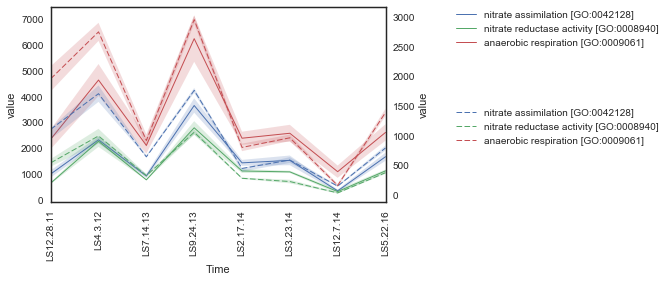

In [473]:
#Plot

#Repeat with other categories that are in markdown for other panels
#Set style to not have grids
sns.set_style("white")

fig, ax = plt.subplots()
ax = sns.tsplot(time="Time", value = 'value',ci = [50], unit = 'index', condition = "variable", data=MP_GOs_melt, linewidth = 1)
plt.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)
ax.set_xticklabels(dates)
ax2 = ax.twinx()
ax2 = sns.tsplot(time="Time", value = 'value',ci =[50], unit = 'index', condition = "variable", data=MG_GOs_melt, linewidth = 1, linestyle = "--")
plt.legend(bbox_to_anchor=(1.2, 0.5), loc=2, borderaxespad=0.)
fig.autofmt_xdate(rotation = 90, ha = 'center')
#plt.savefig("./Duplicate_Peptide_Filter/MGMP_Anaerobic_Respiration_tsplot.pdf",bbox_inches='tight')

### Figure 4A & 4B - MG & MP Taxa Composition

In [295]:
#Read in data tables

#Metaproteome data table
df = pd.read_csv("./Duplicate_Peptide_Filter/pDB_CSVs/NormalizedDataAll_uniref50.csv", index_col = 'datarest$ProteinID')
df_IGC = pd.read_csv("./Duplicate_Peptide_Filter/IGC_CSVs/NormalizedDataAll.txt", index_col='datarest$ProteinID', sep='\t')

#Metagenome data table
MG = pd.read_csv("../Shotgun/Salmon_CPMs_Uniprot_Alignment.csv")
#Remove the genes with duplicate queryIDs
MG = MG.drop_duplicates(subset = 'queryID', keep = 'first')

In [296]:
#Read in metadata
meta = pd.read_csv('LS_Metadata.txt', sep = '\t', index_col = 'SampleID')
protein_meta_IGC = pd.read_csv('./IGC_Approach/Protein_Metadata(wHuman).csv', index_col = 'datarest$ProteinID')
protein_meta = pd.read_csv('./Duplicate_Peptide_Filter/pDB_UniProtKB.txt', sep = '\t')
protein_taxa = pd.read_csv('../Shotgun/Taxa_annotations_expanded.csv')
MG_ann = pd.read_csv('../Shotgun/MG_UniprotKB_Annotations.txt', sep = '\t')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [297]:
#First make a list of the dates you want to average and get the standard deviation for
dates = ['LS12.28.11','LS4.3.12','LS7.14.13','LS9.24.13','LS2.17.14','LS3.23.14','LS12.7.14','LS5.22.16']

In [298]:
#Generate averages and standard deviations for the technical replicates
for i in dates:
    avgstd(df,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

In [299]:
for i in dates:
    avgstd(MG,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

In [300]:
#Annotate your proteins with the uniref50, uniprotKB equivalents & taxa aligned from the custom database
MG = MG.merge(MG_ann, left_on = 'queryID', right_on = 'Entry', how = 'left')
MG = MG.merge(protein_taxa, left_on = 'queryID', right_on = 'Ref_ID', how = 'left')

df = df.merge(MG_ann, left_index = True, right_on = 'Entry', how = 'left')
df = df.merge(protein_taxa, left_on = 'queryID', right_on = 'Ref_ID', how = 'left')

In [302]:
#Aggregate genera sums
dfcategories = df[dates].groupby([df['Genus']]).agg(['sum'])
dfcategories.columns = dfcategories.columns.droplevel(1)
dfcategories2 = MG[dates].groupby([MG['Genus']]).agg(['sum'])
dfcategories2.columns = dfcategories2.columns.droplevel(1)

In [303]:
#Calculate the percent abundances of each genera
for i in dates:
    dfcategories[i] = dfcategories[i]/dfcategories[i].sum()
    dfcategories2[i] = dfcategories2[i]/dfcategories2[i].sum()

In [304]:
#Find the sum of percentage of genera
dfcategories['sum'] = dfcategories.sum(axis = 1)
dfcategories2['sum'] = dfcategories2.sum(axis = 1)

In [305]:
#Remove low abundance genera for visualization purposes
dfcategories = dfcategories[dfcategories['sum'] > 0.03]
dfcategories2 = dfcategories2[dfcategories2['sum'] > 0.03]

In [306]:
#Recalculate percent abundances according to new sums
for i in dates:
    dfcategories[i] = dfcategories[i]/dfcategories[i].sum()
    dfcategories2[i] = dfcategories2[i]/dfcategories2[i].sum()

In [307]:
#Transpose the plot to make it fit the code structure I'm following for the stacked bar chart

#Remove index name
del dfcategories.index.name
#Sort samples by time
order=['LS12.28.11','LS4.3.12','LS7.14.13','LS9.24.13','LS2.17.14','LS3.23.14','LS12.7.14', 'LS5.22.16']
#Transpose
dfcategories = dfcategories.transpose()
#Get the dates in the correct order
dfcategories = dfcategories.reindex(order)
#Get Phyla into an order which depends on the abundance of each phyla for easier interpretation
dfcategories = dfcategories[dfcategories.sum().sort_values(ascending = False).index]

In [308]:
#Randomize Colors for Display
vals = np.linspace(0,1,30)
np.random.shuffle(vals)
my_cmap = plt.cm.colors.ListedColormap(plt.cm.Dark2(vals))

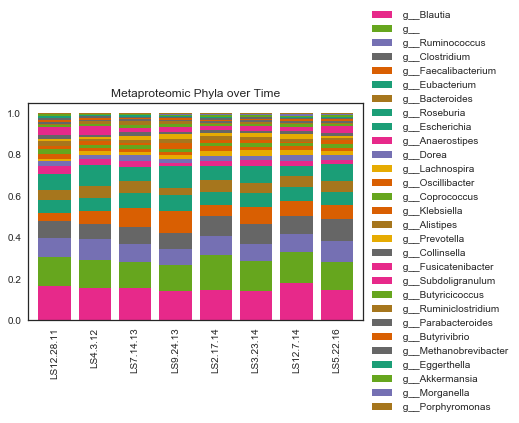

In [311]:
#Bar plot of pDB Genera Abundances
#my_cmap = plt.cm.colors.ListedColormap(plt.cm.Dark2(vals2))
#my_cmap = plt.cm.get_cmap('prism')
plot1 = dfcategories.plot(kind='bar',stacked=True, width = 0.8, colormap=my_cmap, title='Metaproteomic Phyla over Time')
plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plot1
plt.savefig('./pdfs/pDB_Genus_over_Time.pdf',bbox_inches="tight")

In [312]:
#Transpose the plot to make it fit the code structure I'm following for the stacked bar chart

#Remove index name
del dfcategories2.index.name
#Sort samples by time
order=['LS12.28.11','LS4.3.12','LS7.14.13','LS9.24.13','LS2.17.14','LS3.23.14','LS12.7.14', 'LS5.22.16']
#Transpose
dfcategories2 = dfcategories2.transpose()
#Get the dates in the correct order
dfcategories2 = dfcategories2.reindex(order)
#Get Phyla into an order which depends on the abundance of each phyla for easier interpretation
dfcategories2 = dfcategories2[dfcategories2.sum().sort_values(ascending = False).index]

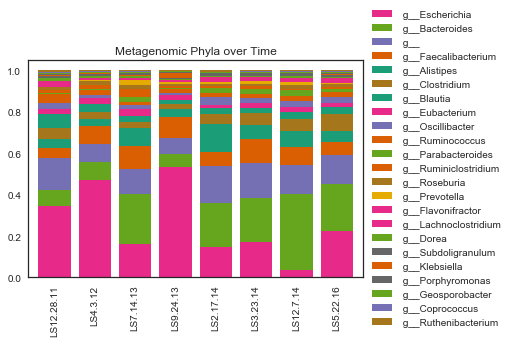

In [314]:
#Bar plot of pDB Genera Abundances
#my_cmap = plt.cm.colors.ListedColormap(plt.cm.Dark2(vals2))
#my_cmap = plt.cm.get_cmap('prism')
plot1 = dfcategories2.plot(kind='bar',stacked=True, width = 0.8, colormap=my_cmap, title='Metagenomic Phyla over Time')
plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plot1
plt.savefig('./pdfs/MG_Genus_over_Time.pdf',bbox_inches="tight")

### Figure 4C & 5B - MG & MP Significant LR Comparisons

In [496]:
#Read in data tables

#Metaproteome data table
df = pd.read_csv("./Duplicate_Peptide_Filter/pDB_CSVs/NormalizedDataAll_uniref50.csv", index_col = 'datarest$ProteinID')
df_IGC = pd.read_csv("./Duplicate_Peptide_Filter/IGC_CSVs/NormalizedDataAll.txt", index_col='datarest$ProteinID', sep='\t')

#Metagenome data table
MG = pd.read_csv("../Shotgun/Salmon_CPMs_Uniprot_Alignment.csv")
#Remove the genes with duplicate queryIDs
MG = MG.drop_duplicates(subset = 'queryID', keep = 'first')

In [497]:
#Read in metadata
meta = pd.read_csv('LS_Metadata.txt', sep = '\t', index_col = 'SampleID')
protein_meta_IGC = pd.read_csv('./IGC_Approach/Protein_Metadata(wHuman).csv', index_col = 'datarest$ProteinID')
protein_meta = pd.read_csv('./Duplicate_Peptide_Filter/pDB_UniProtKB.txt', sep = '\t')
protein_taxa = pd.read_csv('../Shotgun/Taxa_annotations_expanded.csv')
MG_ann = pd.read_csv('../Shotgun/MG_UniprotKB_Annotations.txt', sep = '\t')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [498]:
samples = ['LS3.23.14_2', 'LS5.22.16_3', 'LS12.7.14_3', 'LS4.3.12_3',
       'LS9.24.13_2', 'LS2.17.14_2', 'LS12.28.11_1', 'LS7.14.13_1',
       'LS9.24.13_1', 'LS12.28.11_2', 'LS5.22.16_2', 'LS7.14.13_2',
       'LS4.3.12_2', 'LS12.7.14_1', 'LS3.23.14_3', 'LS2.17.14_3', 'LS4.3.12_1',
       'LS7.14.13_3', 'LS2.17.14_1', 'LS12.28.11_3', 'LS3.23.14_1',
       'LS9.24.13_3', 'LS5.22.16_1', 'LS12.7.14_2']
len(samples)

24

In [499]:
#Annotate your proteins with the uniref50, uniprotKB equivalents & taxa aligned from the custom database
MG = MG.merge(MG_ann, left_on = 'queryID', right_on = 'Entry', how = 'left')
MG = MG.merge(protein_taxa, left_on = 'queryID', right_on = 'Ref_ID', how = 'left')

df = df.merge(MG_ann, left_index = True, right_on = 'Entry', how = 'left')
df = df.merge(protein_taxa, left_on = 'queryID', right_on = 'Ref_ID', how = 'left')

In [500]:
#Remove the human proteins for direct comparisons with microbes only
df_micro = df[df['queryID'].str.contains('k99_') == True]

In [501]:
df_micro.index = df_micro['queryID']

,Unnamed: 0_x,LS3.23.14_2,LS5.22.16_3,LS12.7.14_3,LS4.3.12_3,LS9.24.13_2,LS2.17.14_2,LS12.28.11_1,LS7.14.13_1,LS9.24.13_1,...,Subject_ID,Num,Taxa,Kingdom,Phylum,Class,Order,Famly,Genus,Species
queryID,,,,,,,,,,,,,,,,,,,,,
k99_1000046_1,110,61.067869,118.524388,68.681836,264.014067,171.733269,75.407012,110.085532,124.672957,144.374863,...,G001481375,1550024.0,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Ruminococcaceae,g__Ruthenibacterium,s__Ruthenibacterium lactatiformans
k99_1000192_1,111,132.240162,128.182893,106.207889,113.250556,68.767526,146.534332,115.097499,140.505533,54.954461,...,G900066845,165186.0,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Ruminococcaceae,g__Ruminococcus,s__uncultured Ruminococcus sp.
k99_100028_3,112,119.321443,118.902113,86.733568,115.623387,172.694078,110.145594,168.940314,69.936235,NaN,...,G000436215,1262952.0,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Ruminococcaceae,g__Ruminococcus,s__Ruminococcus sp. CAG:177
k99_100044_2,114,77.675573,80.351490,181.768393,39.106655,97.539981,98.553995,61.926157,195.475603,NaN,...,G001535615,28116.0,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__Bacteroides ovatus
k99_100044_3,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,163.342699,...,G001578575,28116.0,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__Bacteroides ovatus
k99_1000497_2,116,131.543532,119.071840,241.041094,149.645728,82.554611,107.933536,155.855524,151.054945,111.326412,...,G001404855,39491.0,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,g__,s__[Eubacterium] rectale
k99_1000512_1,117,135.625310,117.325487,118.977517,63.209572,173.799545,179.143850,130.884341,109.407693,NaN,...,G000432355,1262881.0,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Eubacteriaceae,g__Eubacterium,s__Eubacterium sp. CAG:161
k99_1000590_1,118,33.969219,21.335567,9.847595,455.562096,356.137409,29.749954,59.457066,12.214501,346.342804,...,G001916465,39485.0,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Eubacteriaceae,g__Eubacterium,s__[Eubacterium] eligens
k99_100074_1,119,92.117803,118.179735,126.085403,153.592976,175.982772,78.502470,123.120660,146.802967,136.341723,...,G000436615,1262755.0,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,g__Blautia,s__Blautia sp. CAG:237


In [502]:
#First make a list of the dates you want to average and get the standard deviation for
dates = ['LS12.28.11','LS4.3.12','LS7.14.13','LS9.24.13','LS2.17.14','LS3.23.14','LS12.7.14','LS5.22.16']

In [503]:
#Find the averages of each dataset
for i in dates:
    avgstd(df_micro,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [504]:
for i in dates:
    avgstd(MG,"%s" %(i), "%s_Std" %(i), "%s_1" % (i), "%s_2" % (i), "%s_3" % (i))

In [505]:
df = df_micro[dates]

In [506]:
#Generate a column for each of the three IBD activity markers

df.loc['Lysozyme'] = meta['Lysozyme C (MS)'].astype('float')
df.loc['Calprotectin'] = meta['Calprotectin (MS)'].astype('float')
df.loc['CRP'] = meta['CRP'].astype('float')

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [507]:
#Generate a list that is sorted by increasing values of the metadata of interest
#Cal_order = list(meta['Lysozyme C (MS)'].sort_values().index)
Cal_order = list(meta['Calprotectin (MS)'].sort_values().index)
#Cal_order = list(meta['CRP'].sort_values().index)

In [508]:
#List the linear regression statistics for later
linregstats =['slope','intercept','rvalue','pvalue','stderr']

for i in linregstats:
    Cal_order.append(i)

In [509]:
#Generate two transposed versions of the dataframe for the linear regressions
df_m = df.T
df_n = df

In [510]:
#Reindex to align for linear regression
df_n.reindex(columns = Cal_order)

,LS12.7.14,LS3.23.14,LS4.3.12,LS7.14.13,LS9.24.13,LS5.22.16,LS2.17.14,LS12.28.11,slope,intercept,rvalue,pvalue,stderr
queryID,,,,,,,,,,,,,
k99_1000046_1,73.967680,60.186253,221.047163,120.275521,158.054066,111.764665,81.217977,137.834791,NaN,NaN,NaN,NaN,NaN
k99_1000192_1,101.460375,134.723026,115.927840,133.751317,66.684417,130.849396,145.425579,110.427409,NaN,NaN,NaN,NaN,NaN
k99_100028_3,86.733568,119.321443,115.623387,69.936235,172.694078,118.902113,110.145594,168.940314,NaN,NaN,NaN,NaN,NaN
k99_100044_2,160.561600,84.939164,75.584058,163.042306,79.668770,92.413213,85.960781,83.376280,NaN,NaN,NaN,NaN,NaN
k99_100044_3,89.167111,82.985652,105.264589,58.016207,163.342699,138.191467,180.354974,275.244328,NaN,NaN,NaN,NaN,NaN
k99_1000497_2,145.514319,126.167795,147.670285,112.577083,96.909731,119.359240,119.266927,129.301821,NaN,NaN,NaN,NaN,NaN
k99_1000512_1,102.719917,106.914974,58.583047,94.869180,193.560415,104.582688,231.895774,115.665134,NaN,NaN,NaN,NaN,NaN
k99_1000590_1,14.122677,44.319065,343.415287,10.782946,551.770328,15.665993,28.097482,44.115790,NaN,NaN,NaN,NaN,NaN
k99_100074_1,120.375431,84.955992,151.882825,133.959840,151.034682,111.686874,79.765739,108.318433,NaN,NaN,NaN,NaN,NaN


In [513]:
slope = []
intercept = []
rvalue = []
pvalue = []
stderr = []
for i in df_m:
    a = df_n.loc[i]
    b = df_n.loc[#'CRP'
            'Calprotectin'
            #'Lysozyme'
        ]
    linres = linregress(a[dates],b[dates])
    #linres = linregress(df_n.loc[i], df_n.loc[#'CRP'
            #'Calprotectin'
            #'Lysozyme'
                                             #])
    slope.append(linres.slope)
    intercept.append(linres.intercept)
    rvalue.append(linres.rvalue)
    pvalue.append(linres.pvalue)
    stderr.append(linres.stderr)
df_n['slope'] = slope
df_n['intercept'] = intercept
df_n['rvalue'] = rvalue
df_n['pvalue'] = pvalue
df_n['stderr'] = stderr
df_n

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,LS12.28.11,LS4.3.12,LS7.14.13,LS9.24.13,LS2.17.14,LS3.23.14,LS12.7.14,LS5.22.16,slope,intercept,rvalue,pvalue,stderr
queryID,,,,,,,,,,,,,
k99_1000046_1,137.834791,221.047163,120.275521,158.054066,81.217977,60.186253,73.967680,111.764665,-0.122265,150.694542,-0.061757,8.845001e-01,0.806698
k99_1000192_1,110.427409,115.927840,133.751317,66.684417,145.425579,134.723026,101.460375,130.849396,1.274932,-13.728530,0.308310,4.575065e-01,1.605958
k99_100028_3,168.940314,115.623387,69.936235,172.694078,110.145594,119.321443,86.733568,118.902113,1.119123,1.340215,0.384479,3.469955e-01,1.096970
k99_100044_2,83.376280,75.584058,163.042306,79.668770,85.960781,84.939164,160.561600,92.413213,-1.137729,253.362247,-0.400107,3.260189e-01,1.063910
k99_100044_3,275.244328,105.264589,58.016207,163.342699,180.354974,82.985652,89.167111,138.191467,1.248207,-34.512399,0.839733,9.093922e-03,0.329510
k99_1000497_2,129.301821,147.670285,112.577083,96.909731,119.266927,126.167795,145.514319,119.359240,-0.914402,249.887042,-0.147459,7.274969e-01,2.503904
k99_1000512_1,115.665134,58.583047,94.869180,193.560415,231.895774,106.914974,102.719917,104.582688,0.817531,32.866581,0.449135,2.642685e-01,0.663939
k99_1000590_1,44.115790,343.415287,10.782946,551.770328,28.097482,44.319065,14.122677,15.665993,-0.158910,156.858690,-0.311186,4.530992e-01,0.198124
k99_100074_1,108.318433,151.882825,133.959840,151.034682,79.765739,84.955992,120.375431,111.686874,-1.876744,356.938244,-0.492143,2.154043e-01,1.355233


In [514]:
pvals = df_n['pvalue']

In [515]:
BH_stats = fdrcorrection(pvals, alpha = 0.2, method = 'indep')

In [516]:
adj_pval = BH_stats[1]

In [517]:
df_n['pvalue_adj'] = adj_pval

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [564]:
df_sig = df_n[df_n['pvalue'] < 0.05]

In [565]:
#Retrieve prodigal alignments to the uniref_50
Uniprot = pd.concat([MG['queryID'],MG['subjectID']], axis = 1).drop_duplicates()
#Add annotation information on the shared dataframe
df_sig = df_sig.merge(Uniprot, left_index = True, right_on = "queryID")#, how = 'left')
df_sig = df_sig.merge(protein_taxa, left_on = 'queryID', right_on = 'Ref_ID')#, how = 'left')
df_sig = df_sig.merge(MG_ann, left_on = 'subjectID', right_on = "Entry")

In [566]:
#Figure 5B uses this code

#Split up protein metadata for MG and sum it at for the desired variable
s = df_sig['Cross-reference (eggNOG)'].str.split(';').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1) # to line up with df's index
s.name = 'Parsed_Categories'
GO = df_sig.join(s)
GO['Parsed_Categories'] = GO['Parsed_Categories'].str.strip()
df_sig3 = GO.merge(COG_cats, left_on = 'Parsed_Categories', right_on = 'COG', how = 'left')
df_sig3 = df_sig3.merge(Cat_key, left_on = 'eggNOG_Code', right_on = 'eggNOG Functional Assignment', how = 'left')
df_sig3 = df_sig3.merge(COG, left_on = 'COG', right_on = 'COG', how = 'left')
#Add an additional step specifically for the proteins mapping to multiple COG which are of the same Description...
labels = ['Ref_ID','Parsed_Categories']
df_sig3['Ref_eggNOG'] = df_sig3['Ref_ID']+" "+df_sig3['Description']
df_sig3['Ref_eggNOG']
#Drop to keep only 1 category/description per reference
df_sig4 = df_sig3.drop_duplicates(subset = 'Ref_eggNOG', keep = 'first')
df_sig = df_sig4

In [567]:
#Subset out the significant positive and negative correlations
Cal_neg = df_sig[df_sig['rvalue'] < 0]
Cal_pos = df_sig[df_sig['rvalue'] > 0]

In [568]:
#Use this code if you want to simply look at quantity of significant proteins
Cal_neg['Cal_Pos'] = 0
Cal_pos['Cal_Pos'] = 1
Cal_neg['Cal_Neg'] = 1
Cal_pos['Cal_Neg'] = 0

/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/rhmills/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [569]:
df_sig = pd.concat([Cal_neg, Cal_pos])

In [571]:
#Sum by category

#Use this for eggNOG category
dfcategories = df_sig[['Cal_Neg','Cal_Pos']].groupby([df_sig['Description']]).agg(['sum'])
#Use this for Genera
#dfcategories = df_sig[['Cal_Neg','Cal_Pos']].groupby([df_sig['Genus']]).agg(['sum'])
dfcategories.columns = dfcategories.columns.droplevel(1)

In [572]:
#Save the postive and negative correlations per genera
#dfcategories.to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/CRPSig05_pDB_Ratios_Phylum(nopseudo).csv')
dfcategories

,Cal_Neg,Cal_Pos
Description,,
Amino acid transport and metabolism,3,8
Carbohydrate transport and metabolism,9,21
"Cell cycle control, cell division, chromosome partitioning",0,1
Cell wall/membrane/envelope biogenesis,0,2
Coenzyme transport and metabolism,1,2
Defense mechanisms,1,2
Energy production and conversion,7,19
Function unknown,0,3
General function prediction only,2,7


In [573]:
#Add a Pseudocount of 1 so that the categories without anything are still shown
dfcategories = dfcategories.replace(0,1)
dfcategories

,Cal_Neg,Cal_Pos
Description,,
Amino acid transport and metabolism,3,8
Carbohydrate transport and metabolism,9,21
"Cell cycle control, cell division, chromosome partitioning",1,1
Cell wall/membrane/envelope biogenesis,1,2
Coenzyme transport and metabolism,1,2
Defense mechanisms,1,2
Energy production and conversion,7,19
Function unknown,1,3
General function prediction only,2,7


In [574]:
#Find the ratios necessary for calculating the ratio of ratios
dfcategories['Percent_Neg'] = \
dfcategories['Cal_Neg']/dfcategories['Cal_Neg'].sum()
dfcategories['Percent_Pos'] = \
dfcategories['Cal_Pos']/dfcategories['Cal_Pos'].sum()

In [575]:
dfcategories['Ratio of Percentages (Pos/Neg)'] = dfcategories['Percent_Pos']/dfcategories['Percent_Neg']
dfcategories

,Cal_Neg,Cal_Pos,Percent_Neg,Percent_Pos,Ratio of Percentages (Pos/Neg)
Description,,,,,
Amino acid transport and metabolism,3,8,0.053571,0.074766,1.395639
Carbohydrate transport and metabolism,9,21,0.160714,0.196262,1.221184
"Cell cycle control, cell division, chromosome partitioning",1,1,0.017857,0.009346,0.523364
Cell wall/membrane/envelope biogenesis,1,2,0.017857,0.018692,1.046729
Coenzyme transport and metabolism,1,2,0.017857,0.018692,1.046729
Defense mechanisms,1,2,0.017857,0.018692,1.046729
Energy production and conversion,7,19,0.125000,0.177570,1.420561
Function unknown,1,3,0.017857,0.028037,1.570093
General function prediction only,2,7,0.035714,0.065421,1.831776


In [ ]:
#Save the ratios and repeat for Metagenome...
#Plot the ratio of ratios of the metaproteome side by side with the metagenome
#dfcategories.to_csv('./Duplicate_Peptide_Filter/LR Significant Correlations/LYSSig05_pDB_Ratios_Phylum(Pseudocount).csv')